In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/engineered_features_unprocessed.csv')

In [3]:
# Same as for random forest

categorical_cols = ['sex', 'smoker', 'region', 'bmi_category', 'age_group', 'bmi_risk_tier']

numerical_cols = ['age', 'bmi', 'children', 'age_squared', 'age_cubed', 'sqrt_age', 
                 'log_age', 'is_obese', 'bmi_squared', 'log_bmi', 'age_bmi', 
                 'smoker_numeric', 'age_smoker', 'age_bmi_smoker', 'is_high_risk', 
                 'is_young_smoker', 'is_old_smoker', 'has_children', 'many_children', 
                 'age_per_child', 'children_bmi', 'region_avg_expense', 
                 'is_northwest', 'smoker_northwest', 'is_southwest', 'smoker_southwest', 
                 'is_southeast', 'smoker_southeast', 'is_northeast', 'smoker_northeast', 
                 'age_premium_factor', 'family_risk', 'smoker_severity']

target_col = 'expenses'

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('scaler', StandardScaler())]), numerical_cols),
        ('cat', Pipeline(steps=[('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))]), categorical_cols)
    ])

In [4]:
X = df[numerical_cols + categorical_cols]
y = df[target_col]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1004)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [6]:
def evaluate_model(model, X, y, name="Model"):
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    print(f"{name} - RMSE: {rmse:.2f}, R²: {r2:.4f}")
    return rmse, r2

In [7]:
xgb_param_grid = {
    'learning_rate': [0.005, 0.01, 0.03, 0.05, 0.08, 0.1, 0.15, 0.2, 0.3],
    'n_estimators': [50, 100, 150, 200, 250, 300, 400],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [1, 2, 3, 4, 5, 6],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.5, 0.7, 0.9, 1.0],
    'gamma': [0, 0.05, 0.1, 0.2, 0.3, 0.5],
    'reg_alpha': [0, 0.1, 0.5, 1, 2, 5, 10],
    'reg_lambda': [0, 0.1, 1, 5, 10, 20],
    'scale_pos_weight': [1, 3, 5]
}

In [8]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=1004,
    n_jobs=-1
)

In [9]:
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=25,
    scoring='neg_root_mean_squared_error',
    cv=10,
    verbose=1,
    random_state=1004,
    n_jobs=-1
)

In [10]:
xgb_random_search.fit(X_train_processed, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                        'learning_rate': [0.005, 0.01, 0.03,
                                                          0.05, 0.08, 0.1, 0.15,
                                                          0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 400],
                                        'reg_alpha': [0, 0.1, 0.5, 1, 2, 5, 10],
                                        'reg_lambda': [0, 0.1, 1, 5, 10, 20],
                                        'scale_pos_weight': [1, 3, 5],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   random_state=1004, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [11]:
print("\nBest XGBoost Parameters:")
print(xgb_random_search.best_params_)
print(f"Best CV RMSE: {-xgb_random_search.best_score_:.4f}")
best_xgb = xgb_random_search.best_estimator_


Best XGBoost Parameters:
{'subsample': 1.0, 'scale_pos_weight': 1, 'reg_lambda': 20, 'reg_alpha': 5, 'n_estimators': 50, 'min_child_weight': 6, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.3, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0}
Best CV RMSE: 4402.4628


In [12]:
xgb_rmse, xgb_r2 = evaluate_model(best_xgb, X_test_processed, y_test, "Best XGBoost")

Best XGBoost - RMSE: 4852.85, R²: 0.8074


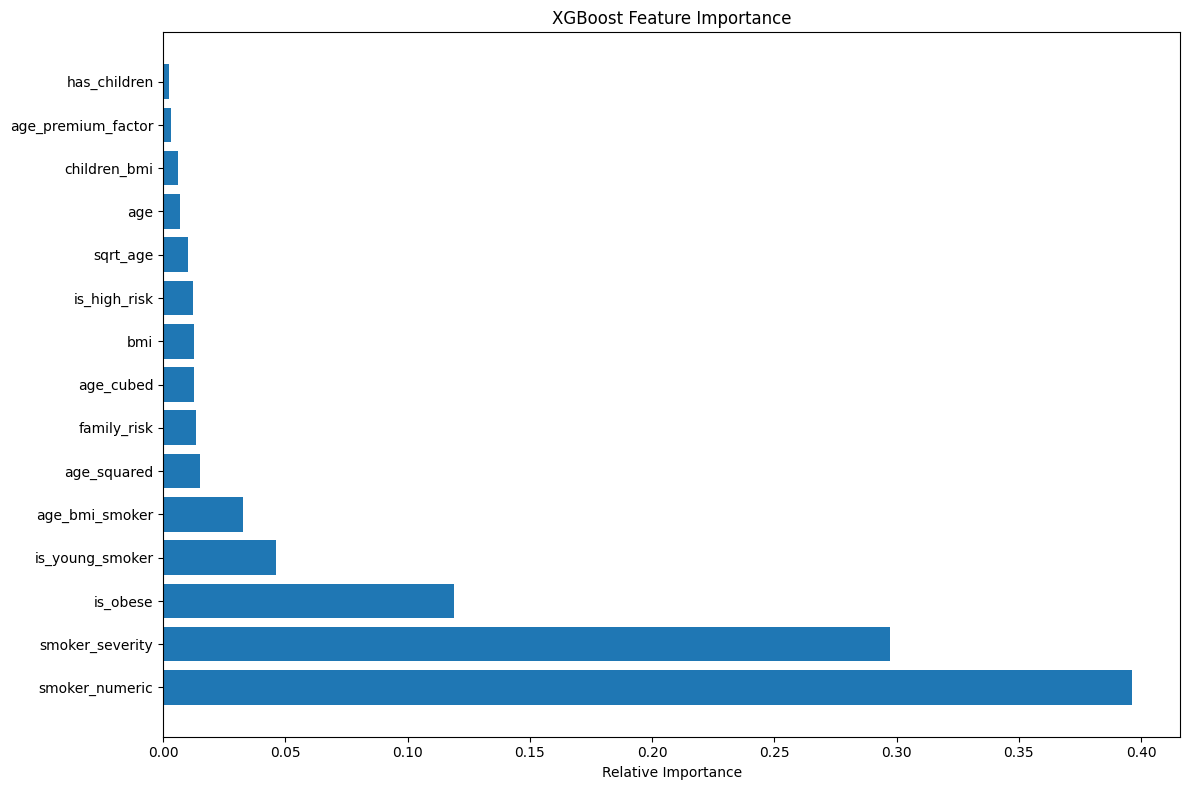

In [13]:
feature_names = numerical_cols + list(preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols))
xgb_importances = best_xgb.feature_importances_

plt.figure(figsize=(12, 8))
indices = np.argsort(xgb_importances)[::-1]
plt.title('XGBoost Feature Importance')
plt.barh(range(15), xgb_importances[indices][:15], align='center')
plt.yticks(range(15), [feature_names[i] for i in indices[:15]])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

In [14]:
best_lr = xgb_random_search.best_params_['learning_rate']
best_n_est = xgb_random_search.best_params_['n_estimators']
best_max_depth = xgb_random_search.best_params_['max_depth']
best_min_child = xgb_random_search.best_params_['min_child_weight']
best_subsample = xgb_random_search.best_params_['subsample']
best_colsample = xgb_random_search.best_params_['colsample_bytree']
best_gamma = xgb_random_search.best_params_['gamma']
best_alpha = xgb_random_search.best_params_['reg_alpha']
best_lambda = xgb_random_search.best_params_['reg_lambda']

In [15]:
focused_xgb_param_grid = {
    'learning_rate': [max(0.01, best_lr-0.02), best_lr, min(0.3, best_lr+0.02)],
    'n_estimators': [max(50, best_n_est-50), best_n_est, min(300, best_n_est+50)],
    'max_depth': [max(1, best_max_depth-1), best_max_depth, min(12, best_max_depth+1)],
    'min_child_weight': [max(1, best_min_child-1), best_min_child, min(7, best_min_child+1)],
    'subsample': [max(0.5, best_subsample-0.1), best_subsample, min(1.0, best_subsample+0.1)],
    'colsample_bytree': [max(0.5, best_colsample-0.1), best_colsample, min(1.0, best_colsample+0.1)]
}

In [16]:
xgb_focused_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=focused_xgb_param_grid,
    n_iter=25,
    scoring='neg_root_mean_squared_error',
    cv=10,
    verbose=1,
    random_state=1004,
    n_jobs=-1
)

In [17]:
xgb_focused_search.fit(X_train_processed, y_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                          n_estimators=None, n_jobs=-1,
                                          num_parallel_tree=None,
                                          random_state=1004, ...),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.5, 0.6],
                                        'learning_rate': [0.13, 0.15,
                                                          0.16999999999999998],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [5, 6, 7],
                                        'n_estimators': [50, 50, 100],
                                        'subsample': [0.9, 1.0, 1.0]},
                   random_state=1004, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [18]:
print(xgb_focused_search.best_params_)
print(f"Best CV RMSE: {-xgb_focused_search.best_score_:.4f}")
best_focused_xgb = xgb_focused_search.best_estimator_

{'subsample': 0.9, 'n_estimators': 50, 'min_child_weight': 6, 'max_depth': 3, 'learning_rate': 0.15, 'colsample_bytree': 0.5}
Best CV RMSE: 4340.7324


In [19]:
xgb_focused_rmse, xgb_focused_r2 = evaluate_model(best_focused_xgb, X_test_processed, y_test, "Best Focused XGBoost")
if xgb_focused_rmse < xgb_rmse:
    final_xgb = best_focused_xgb
    print("\nSaving focused")
else:
    final_xgb = best_xgb
    print("\nSaving initial")

joblib.dump(final_xgb, 'models/xgboost_model.pkl')

Best Focused XGBoost - RMSE: 4884.41, R²: 0.8049

Saving initial


['models/xgboost_model.pkl']

In [20]:
predictions_df = pd.read_csv('data/model_predictions.csv')
    
xgb_predictions = final_xgb.predict(X_test_processed)
predictions_df['xgb_predictions'] = xgb_predictions

predictions_df.to_csv('data/model_predictions.csv', index=False)

In [21]:
# Save the preprocess for test set

joblib.dump(preprocessor, 'models/preprocessor.pkl')

['models/preprocessor.pkl']